In [68]:
# ! pip install hyperopt

In [69]:
from ricatti_observer_class import riccati_observer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [70]:
def objective(args): # can also set different case
    current_time = 0
    total_error_p = 0
    total_error_r = 0
    count = 0
    k, q, v1, v2 = args # argument that need to be tuned
    start_time = time.time()
    riccati_obj = riccati_observer(
        use_adaptive            = True,
        quaternion              = True,
        time                    = (0, 40),
        stepsize                = 0.1,
        tol                     = 1e-2 * 3,
        noise                   = False,
        which_eq                = 0,
        which_omega             = "full",
        with_image_hz_sim       = False,
        image_hz                = 60, 
        randomize_image_input   = False,
        p_hat                   = np.array([[-2, 4, 3]], dtype=np.float64).T,
        Lambda_bar_0            = np.array([np.sqrt(2)/2, np.sqrt(2)/2, 0,  0]).T,  # quaternion: w, x, y, z
        z_appear                = np.array([[[2.5, 2.5, 0]], [[5, 0, 0]], [[0, 0, 0]]]),
        k                       = k,
        q                       = [q], 
        v                       = np.array([v1, v2]),
        p_ricatti               = np.array([1, 100])
        )
    while current_time <= riccati_obj.time[1]:
        current_time, dt_step, soly = riccati_obj.step_simulation()
        Actual_R = riccati_obj.rodrigues_formula(soly[:4])
        Estimate_R = riccati_obj.rodrigues_formula(soly[4:8])
        Estimate_p_bar = soly[8:11]
        Actual_p = np.array([2.5+2.5*np.cos(0.4*current_time), 2.5*np.sin(0.4*current_time), 10])
        Actual_p_bar = np.matmul(np.transpose(np.array(Actual_R).reshape((3,3))), Actual_p)
        # p_temp = np.matmul(np.array(Estimate_R).reshape((3,3)), Estimate_p_bar)
        error_p = Actual_p_bar - Estimate_p_bar
        squared_error_p = np.dot(error_p.T, error_p)
        total_error_p += squared_error_p

        error_r = soly[:4] - soly[4:8]
        squared_error_r = np.dot(error_r.T, error_r)
        total_error_r += squared_error_r

        count += 1
    compute_time = time.time() - start_time
    error_weight_p = 0.6
    error_weight_r = 0.8
    time_weight = 0.2
    score = (error_weight_p/(error_weight_p + time_weight + error_weight_r) * (total_error_p/count) 
    + time_weight/(error_weight_p + time_weight + error_weight_r) * compute_time
    + error_weight_r/(error_weight_p + time_weight + error_weight_r) * (total_error_r/count) )
    return score

from hyperopt import hp
space = (hp.uniform('k', 1, 20),
         hp.uniform('q', 0, 2),
         hp.uniform('v1', 0, 2),
         hp.uniform('v2', 0, 2))

# minimize the objective over the space
from hyperopt import fmin, tpe, space_eval
best = fmin(objective, space, algo=tpe.suggest, max_evals=10)

print(best)
print(space_eval(space, best))

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [03:52<00:00, 23.22s/trial, best loss: 3.1735461873687996]
{'k': 18.68142890255728, 'q': 0.7488088033888922, 'v1': 0.0651386324996206, 'v2': 0.7898774195840963}
(18.68142890255728, 0.7488088033888922, 0.0651386324996206, 0.7898774195840963)


In [71]:
riccati_obj = riccati_observer(
    use_adaptive            = True,
    quaternion              = True,
    time                    = (0, 100),
    stepsize                = 0.1,
    tol                     = 1e-2 * 3,
    noise                   = False,
    which_eq                = 0,
    which_omega             = "full",
    with_image_hz_sim       = False,
    image_hz                = 60, 
    randomize_image_input   = False,
    p_hat                   = np.array([[-2, 4, 3]], dtype=np.float64).T,
    Lambda_bar_0            = np.array([np.sqrt(2)/2, np.sqrt(2)/2, 0,  0]).T,  # quaternion: w, x, y, z
    z_appear                = np.array([[[2.5, 2.5, 0]], [[5, 0, 0]], [[0, 0, 0]]]),
    k                       = best['k'],
    q                       = [best['q']], 
    v                       = np.array([best['v1'], best['v2']]),
    p_ricatti               = np.array([1, 100])
    )

In [72]:
riccati_obj.full_simulation()

Simulation time: 99.99887698937718      Run time: 176.96700167655945366



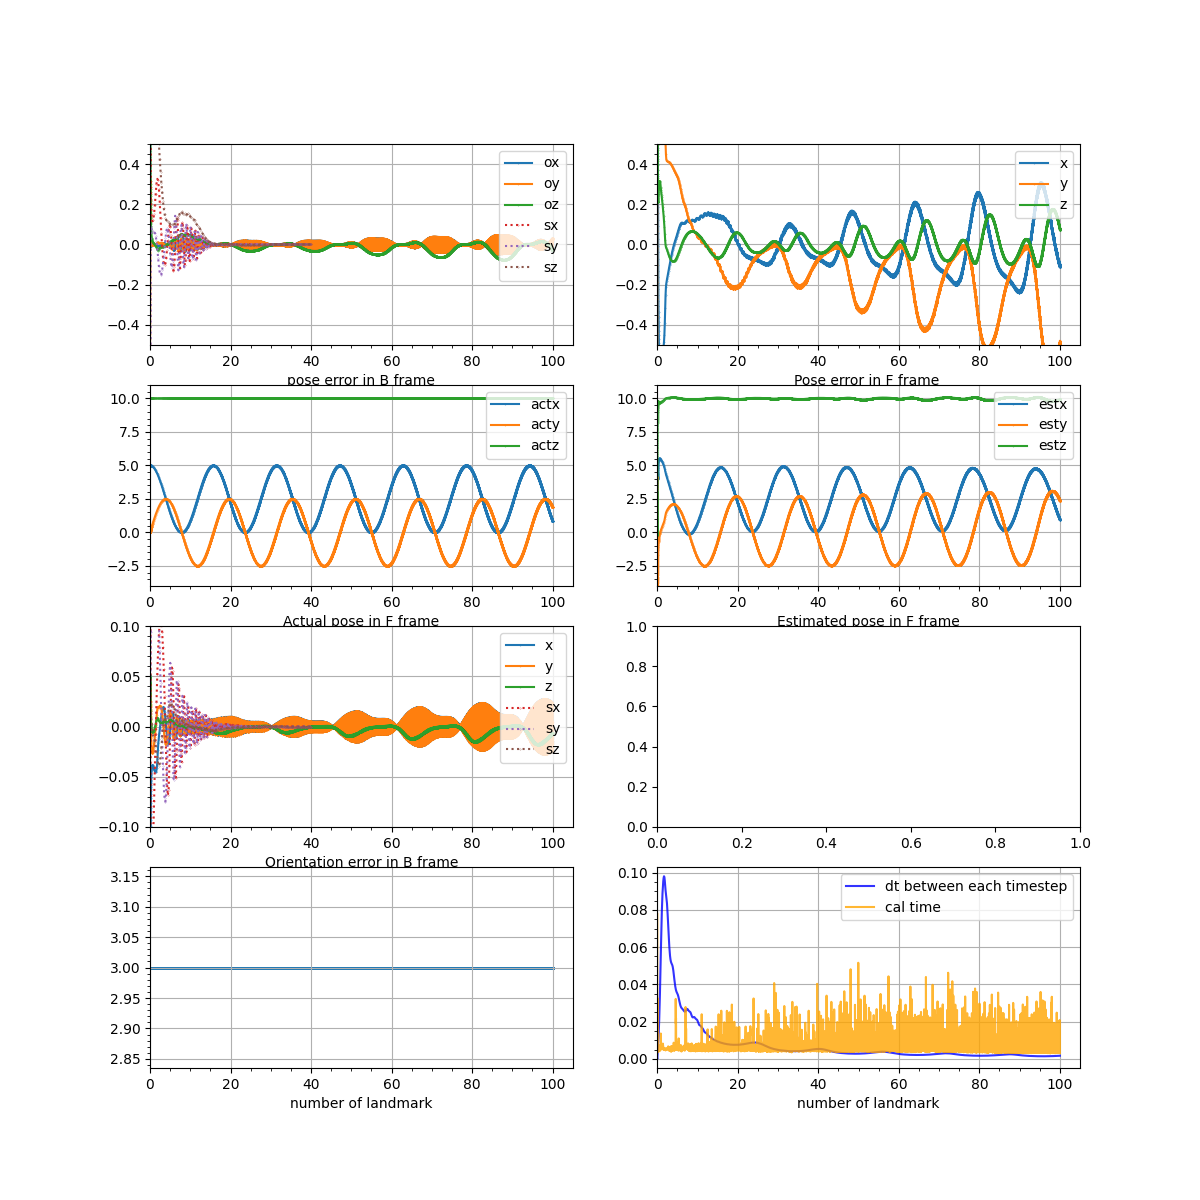

In [73]:
%matplotlib widget
riccati_obj.visual_plot(figsize=(12,12), bound_y=True)  